## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

In [1]:
# import os
import keras

# Disable GPU
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
  x = x / 255.
  if flatten:
    x = x.reshape((len(x), -1))
  return x

def preproc_y(y, num_classes=10):
  if y.shape[-1] == 1:
    y = keras.utils.to_categorical(y, num_classes)
  return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.regularizers import l1_l2
def build_mlp(input_shape, num_out=10, num_neuron=[1024, 1024, 512, 512, 256, 256], l1_ratio=0.0, l2_ratio=0.0):
  """Code Here
  建立你的神經網路
  """
  input_layer = keras.layers.Input(input_shape)
  for i, num in enumerate(num_neuron):
    if i == 0:
      x = keras.layers.Dense(
          units=num, 
          activation='relu', 
          name=f'hidden_layer{i}',
          kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(input_layer)
    else:
      x = keras.layers.Dense(
          units=num, 
          activation='relu', 
          name=f'hidden_layer{i}',
          kernel_regularizer=l1_l2(l1=l1_ratio, l2=l2_ratio))(x)
  
  out = keras.layers.Dense(units=num_out, activation='softmax', name='output_layer')(x)
  model = keras.models.Model(inputs=input_layer, outputs=out)
  
  return model

In [6]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-3
EPOCHS = 30
BATCH_SIZE = 256
MOMENTUM = 0.95
L1_EXP = [0.0, 1e-3, 1e-6]
L2_EXP = [0.0, 1e-3, 1e-6]

In [7]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for L1_reg in L1_EXP:
  for L2_reg in L2_EXP:
    keras.backend.clear_session()

    print(f"Experiment with Regulization Ratio : L1-{L1_reg} L2-{L2_reg}")
    model = build_mlp(input_shape=x_train.shape[1:], l1_ratio=L1_reg ,l2_ratio=L2_reg)    
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = f'L1:{L1_reg} L2:{L2_reg}'
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}

Experiment with Regulization Ratio : L1-0.0 L2-0.0
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer0 (Dense)        (None, 1024)              3146752   
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              1049600   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 512)               524800    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 512)               262656    
_________________________________________________________________
hidden_layer4 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_lay

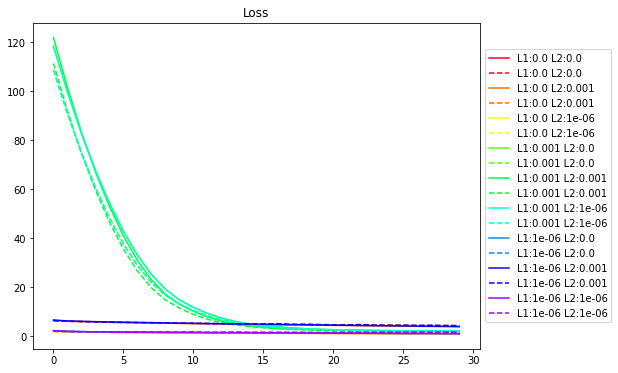

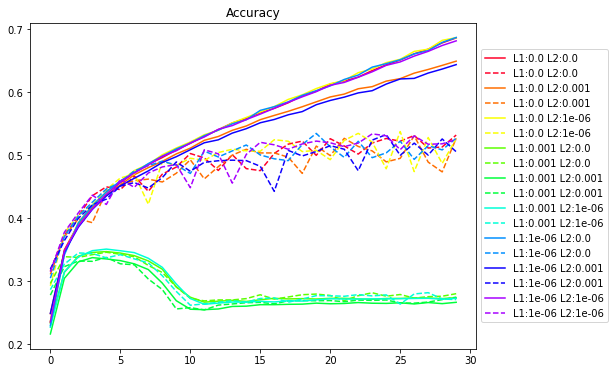

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""

NUM_COLORS = len(results.keys())
cm = plt.get_cmap('gist_rainbow')
color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]


plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()